In [1]:
import pandas as pd
import numpy as np

/var/folders/c4/gkmrtv514ws3wdlf2v6m1brh0000gn/T/ipykernel_57126/2162656668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data_dir_path = 'data/'

train_csv_file_path = data_dir_path + 'train_ship_segmentations_v2.csv'
train_image_dir_path = data_dir_path + 'train_v2/'

train_csv_file_path_clean = data_dir_path + 'train_ship_segmentations_v2_clean.csv'

data_preprocessed_dir_path = 'data_p/'

### Initial preprocessing

In [3]:
df = pd.read_csv(train_csv_file_path)
df['EncodedPixels'] = df['EncodedPixels'].fillna('')

df.head(10)

,ImageId,EncodedPixels
0,00003e153.jpg,
1,0001124c7.jpg,
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


### Explore class imbalance

<Axes: xlabel='HasShip'>

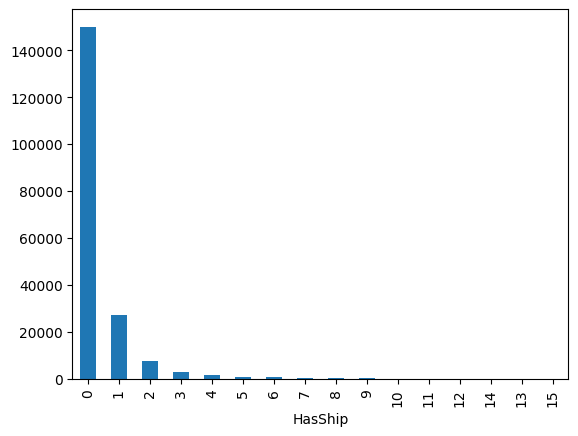

In [4]:
df_ship_count = df.copy()

df_ship_count['HasShip'] = df_ship_count['EncodedPixels'].apply(lambda x: 0 if x == '' else 1)
df_ship_count['HasShip'] = df_ship_count['HasShip'].astype(int)
df_ship_count = df_ship_count.groupby('ImageId').agg({'HasShip': 'sum'}).reset_index()

df_ship_count['HasShip'].value_counts().plot(kind='bar')


In [5]:
df_ship_count_no_ships = df_ship_count[df_ship_count['HasShip'] == 0]
df_ship_count_one_ships = df_ship_count[df_ship_count['HasShip'] == 1]
df_ship_count_two_ships = df_ship_count[df_ship_count['HasShip'] == 2]
df_ship_count_rest_ships = df_ship_count[df_ship_count['HasShip'] > 2]

len(df_ship_count_no_ships), len(df_ship_count_one_ships), len(df_ship_count_two_ships), len(df_ship_count_rest_ships)

(150000, 27104, 7674, 7778)

### Check image files integrity

In [6]:
from os import listdir
image_files = pd.Series(listdir(train_image_dir_path))

image_files.head()

0    db4d6ecd4.jpg
1    4be1d7b76.jpg
2    6961eaf60.jpg
3    d0b573bd5.jpg
4    2702aee48.jpg
dtype: object

In [7]:
df_agregated_image_ids = df_ship_count.copy()['ImageId']

missing_files = df_agregated_image_ids.index[~df_agregated_image_ids.isin(image_files)]
assert len(missing_files) == 0
missing_files

Index([], dtype='int64')

### Sample

In [8]:
def sample_images(n, fix_seed=True):
    if fix_seed:
        np.random.seed(42)

    return pd.concat([
        df_ship_count_no_ships.sample(n), 
        df_ship_count_one_ships.sample(n),
        df_ship_count_two_ships.sample(n),
        df_ship_count_rest_ships.sample(n),
    ])

sample_images(2)

,ImageId,HasShip
76777,660aa4a3b.jpg,0
27418,247888738.jpg,0
19448,19dcc9954.jpg,1
16346,15c1347cd.jpg,1
157450,d18310710.jpg,2
159090,d3b6c4ead.jpg,2
141884,bc96617f8.jpg,6
106217,8d3de19bf.jpg,3


### Preprocess CSV

In [9]:
df_agregated_pixels = df.groupby('ImageId')['EncodedPixels'].apply(lambda x: ' '.join(x)).reset_index()

df_agregated_pixels.head()

,ImageId,EncodedPixels
0,00003e153.jpg,
1,0001124c7.jpg,
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,0001b1832.jpg,


In [10]:
def csv_data(n, fix_seed=True):
    df_ship_count_sampled = sample_images(n, fix_seed)
    out_csv = df_agregated_pixels[df_agregated_pixels['ImageId'].isin(df_ship_count_sampled['ImageId'])]
    return out_csv

csv_data(1)

,ImageId,EncodedPixels
19448,19dcc9954.jpg,354538 4 355300 10 356062 16 356824 22 357588 ...
76777,660aa4a3b.jpg,
141884,bc96617f8.jpg,21206 2 21971 5 22736 9 23502 11 24268 13 2503...
157450,d18310710.jpg,202461 2 203229 5 203996 8 204764 8 205532 8 2...


In [11]:
s_csv = csv_data(5)
s_csv.to_csv(data_preprocessed_dir_path + 's.csv', index=False)

m_csv = csv_data(50)
m_csv.to_csv(data_preprocessed_dir_path + 'm.csv', index=False)

l_csv = csv_data(250)
l_csv.to_csv(data_preprocessed_dir_path + 'l.csv', index=False)